<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/main/Assignment_8/U_net_for_crowod_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)

100%|██████████| 333M/333M [00:16<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = (256, 256)
# Function to generate density map
def generate_density_map(points, shape):
    density = np.zeros(shape, dtype=np.float32)
    for point in points:
        x = min(int(point[0] * shape[1] / shape[1]), shape[1] - 1)
        y = min(int(point[1] * shape[0] / shape[0]), shape[0] - 1)
        density[y, x] += 1
    density = cv2.GaussianBlur(density, (15, 15), 0)
    return density

# Function to load image and .mat file and return image, density map
def load_data(img_paths, gt_paths):
    images, densities = [], []
    for img_path, gt_path in tqdm(zip(img_paths, gt_paths), total=len(img_paths)):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img / 255.0

        mat = loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]
        density = generate_density_map(points, IMAGE_SIZE)

        images.append(img)
        densities.append(density[..., np.newaxis])
    return np.array(images), np.array(densities)

# Provide correct paths
base_path = "/root/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/"

# Train and Test image & gt paths
train_img_paths = sorted(glob(os.path.join(base_path, "train_data/images/*.jpg")))
train_gt_paths  = sorted(glob(os.path.join(base_path, "train_data/ground-truth/*.mat")))

test_img_paths = sorted(glob(os.path.join(base_path, "test_data/images/*.jpg")))
test_gt_paths  = sorted(glob(os.path.join(base_path, "test_data/ground-truth/*.mat")))

# Load data
X_train, Y_train = load_data(train_img_paths, train_gt_paths)
X_test, Y_test   = load_data(test_img_paths, test_gt_paths)
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    bn = Conv2D(512, 3, activation='relu', padding='same')(p3)
    bn = Conv2D(512, 3, activation='relu', padding='same')(bn)

    # Decoder
    u3 = UpSampling2D()(bn)
    u3 = concatenate([u3, c3])
    c4 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)

    u2 = UpSampling2D()(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)

    u1 = UpSampling2D()(c5)
    u1 = concatenate([u1, c1])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(1, 1, activation='linear')(c6)

    model = Model(inputs, outputs)
    return model

model = unet((256, 256, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=25,
    batch_size=8,
    callbacks=callbacks
)


100%|██████████| 182/182 [00:01<00:00, 175.60it/s]


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - loss: 0.0120 - mae: 0.0237 - val_loss: 0.0039 - val_mae: 0.0064
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - loss: 0.0095 - mae: 0.0109 - val_loss: 0.0041 - val_mae: 0.0076
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - loss: 0.0076 - mae: 0.0088 - val_loss: 0.0038 - val_mae: 0.0058
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - loss: 0.0082 - mae: 0.0113 - val_loss: 0.0030 - val_mae: 0.0061
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 0.0056 - mae: 0.0063 - val_loss: 0.0035 - val_mae: 0.0068
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - loss: 0.0082 - mae: 0.0073 - val_loss: 0.0027 - val_mae: 0.0060
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - loss: 0.0059 - mae: 0.0061 - val_loss: 0.0027 - val_mae: 0.0046
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step - loss: 0.0061 - mae: 0.0059 - val_loss: 0.0026 - val_mae: 0.0052
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Ground Truth Count: 256.74
Predicted Count   : 367.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Ground Truth Count: 111.04
Predicted Count   : 410.85


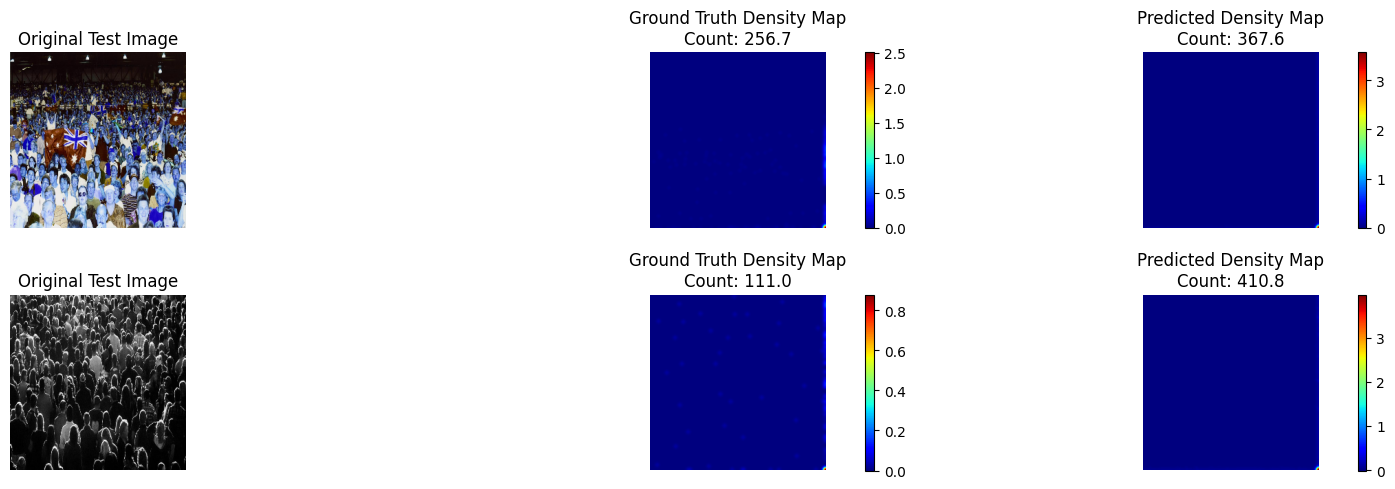

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Choose an index from the test set
indexs = [5, 10]
plt.figure(figsize=(18, 5))
# Get test image, true density map
cnt = 1;
for index in indexs:
  test_img = X_test[index]
  true_density = Y_test[index]


  pred_density = model.predict(np.expand_dims(test_img, axis=0))[0]

  true_count = np.sum(true_density)
  pred_count = np.sum(pred_density)

  print(f"Ground Truth Count: {true_count:.2f}")
  print(f"Predicted Count   : {pred_count:.2f}")
  plt.subplot(2, 3, cnt)
  plt.title("Original Test Image")
  plt.imshow(test_img)
  plt.axis("off")

  cnt += 1
  plt.subplot(2, 3,  cnt)
  plt.title(f"Ground Truth Density Map\nCount: {true_count:.1f}")
  plt.imshow(true_density[..., 0], cmap='jet')
  plt.colorbar()
  plt.axis("off")
  cnt += 1
  plt.subplot(2, 3, cnt)
  cnt += 1
  plt.title(f"Predicted Density Map\nCount: {pred_count:.1f}")
  plt.imshow(pred_density[..., 0], cmap='jet')
  plt.colorbar()
  plt.axis("off")
  plt.tight_layout()
plt.show()

## **MCNN**

In [10]:
# Plot input image, ground truth density, and predicted density

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate
from tensorflow.keras.models import Model

def mcnn_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Column 1 (large receptive field)
    col1 = Conv2D(16, (9, 9), activation='relu', padding='same')(inputs)
    col1 = Conv2D(32, (7, 7), activation='relu', padding='same')(col1)
    col1 = Conv2D(16, (7, 7), activation='relu', padding='same')(col1)

    # Column 2 (medium receptive field)
    col2 = Conv2D(20, (7, 7), activation='relu', padding='same')(inputs)
    col2 = Conv2D(40, (5, 5), activation='relu', padding='same')(col2)
    col2 = Conv2D(20, (5, 5), activation='relu', padding='same')(col2)

    # Column 3 (small receptive field)
    col3 = Conv2D(24, (5, 5), activation='relu', padding='same')(inputs)
    col3 = Conv2D(48, (3, 3), activation='relu', padding='same')(col3)
    col3 = Conv2D(24, (3, 3), activation='relu', padding='same')(col3)

    # Concatenate outputs
    merged = concatenate([col1, col2, col3], axis=-1)
    output = Conv2D(1, (1, 1), activation='linear', padding='same')(merged)

    return Model(inputs, output)

model1 = mcnn_model()
model1.compile(optimizer='adam', loss='mse')
# model1.summary()


In [11]:
# Assuming you have X_train, Y_train, X_test, Y_test prepared
history1 = model1.fit(
    X_train, Y_train,
    epochs=18,
    batch_size=8,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 705ms/step - loss: 0.0329 - val_loss: 0.0041
Epoch 2/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 3/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 4/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 0.0105 - val_loss: 0.0033
Epoch 5/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - loss: 0.0084 - val_loss: 0.0032
Epoch 6/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 7/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 8/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 9/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 10/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 11/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 0.0078 - val_loss: 0.0031
Epoch 12/18
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 18

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Ground Truth Count: 256.74
Predicted Count:    283.17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ground Truth Count: 111.04
Predicted Count:    385.43


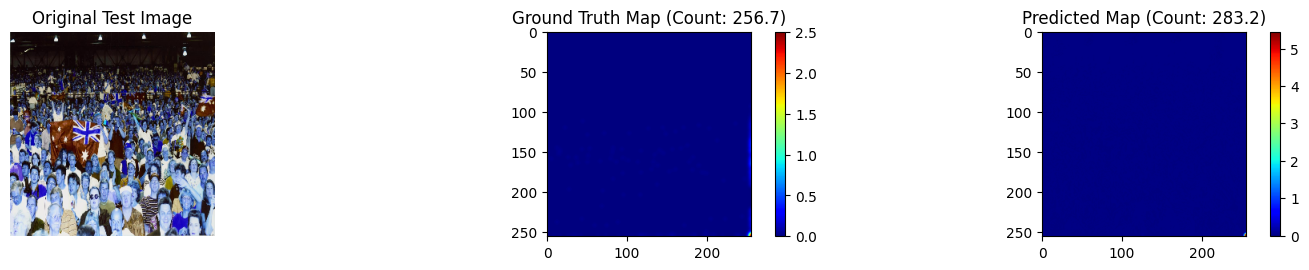

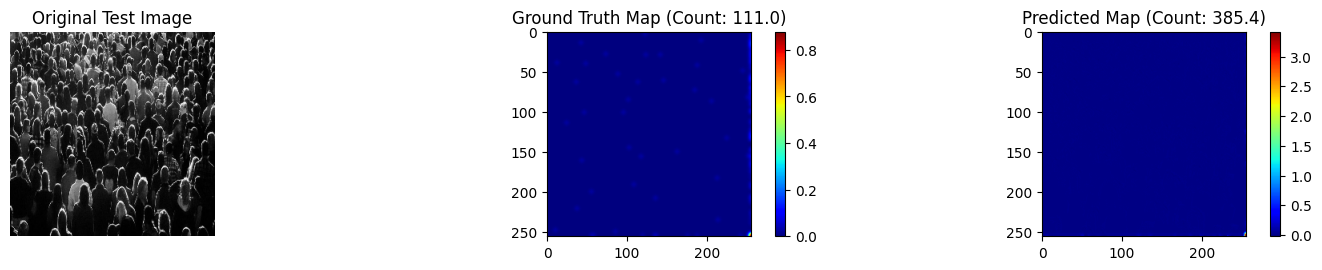

In [13]:
import matplotlib.pyplot as plt
import numpy as np
 # Visualize
# Pick an index from test set
indexs = [5,10]
cnt =1
for index in indexs:
  plt.figure(figsize=(15, 5)) # This line was indented incorrectly
  test_img = X_test[index]
  gt_density = Y_test[index]

  # Predict density map
  pred_density = model1.predict(np.expand_dims(test_img, axis=0))[0]

  # Count
  gt_count = np.sum(gt_density)
  pred_count = np.sum(pred_density)

  print(f"Ground Truth Count: {gt_count:.2f}")
  print(f"Predicted Count:    {pred_count:.2f}")

  plt.subplot(2, 3, cnt)
  cnt += 1
  plt.title("Original Test Image")
  plt.imshow(test_img)
  plt.axis('off')

  plt.subplot(2, 3, cnt)
  cnt += 1
  plt.title(f"Ground Truth Map (Count: {gt_count:.1f})")
  plt.imshow(gt_density[..., 0], cmap='jet')
  plt.colorbar()

  plt.subplot(2, 3, cnt)
  cnt += 1
  plt.title(f"Predicted Map (Count: {pred_count:.1f})")
  plt.imshow(pred_density[..., 0], cmap='jet')
  plt.colorbar()

  plt.tight_layout()
plt.show()

## Comparison

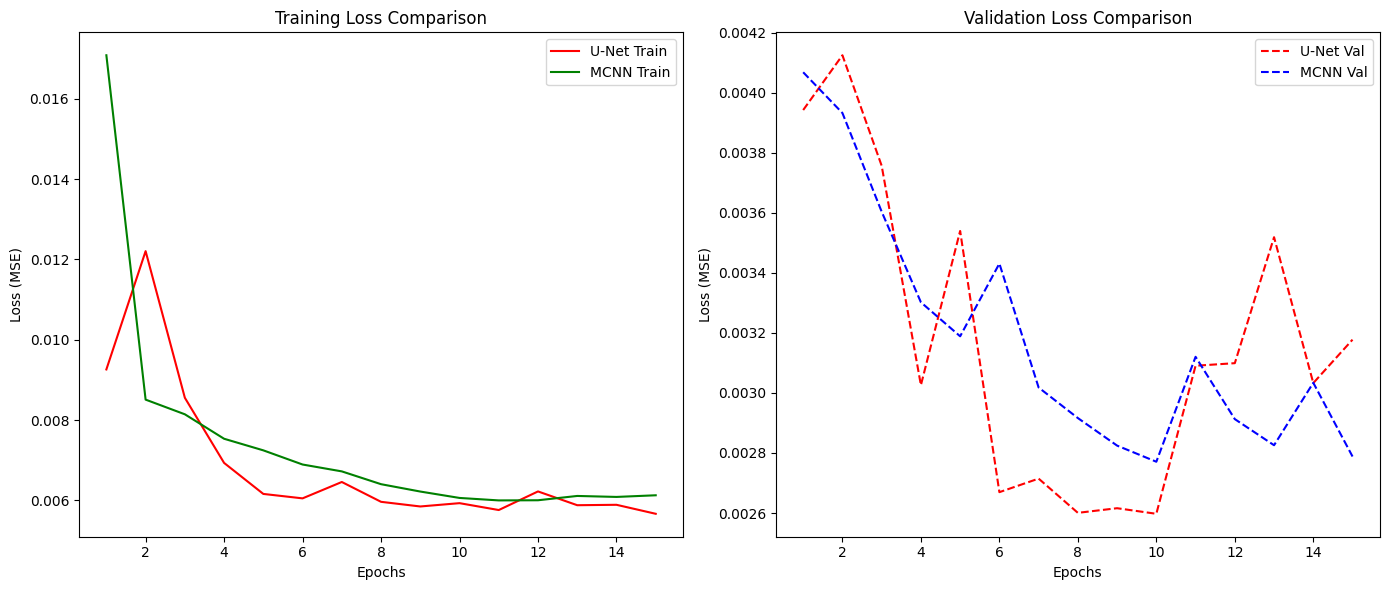

In [16]:
import matplotlib.pyplot as plt

# Extract training and validation loss
unet_train_loss = history.history['loss']
unet_val_loss   = history.history['val_loss']

mcnn_train_loss = history1.history['loss']
mcnn_val_loss   = history1.history['val_loss']

epochs_unet = range(1, len(unet_train_loss) + 1)
epochs_mcnn = range(1, len(mcnn_train_loss) + 1)

plt.figure(figsize=(14, 6))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_unet, unet_train_loss, 'r-', label='U-Net Train')
plt.plot(epochs_mcnn, mcnn_train_loss, 'g-', label='MCNN Train')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_unet, unet_val_loss, 'r--', label='U-Net Val')
plt.plot(epochs_mcnn, mcnn_val_loss, 'b--', label='MCNN Val')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()
